In [65]:
import torch
import numpy as np
import open3d as o3d
from pytorch3d.structures import Meshes, Pointclouds
from pytorch3d.renderer import (
    look_at_view_transform,
    PointsRasterizationSettings,
    PointsRenderer,
    PointsRasterizer,
    AlphaCompositor,
    
    MeshRasterizer,
    MeshRenderer,
    RasterizationSettings,
    HardPhongShader,
    BlendParams
)
from pytorch3d.renderer.cameras import PerspectiveCameras, OrthographicCameras, FoVPerspectiveCameras
from pytorch3d.renderer.mesh.shader import HardPhongShader
from pytorch3d.renderer.mesh.rasterizer import MeshRasterizer
from pytorch3d.renderer import MeshRenderer, Textures

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [66]:
# Load PCD
pcd_o3d = o3d.io.read_point_cloud("/home/airlabs/Dataset/DTU/dtu_4/scan82/dust3r/3/points3d.ply")

# Z축 반전 행렬 정의
flip_transform = np.array([
    [1, 0,  0, 0],
    [0, 1,  0, 0],
    [0, 0, -1, 0],
    [0, 0,  0, 1]
])

# 변환 적용
# pcd_o3d.transform(flip_transform)

points = torch.tensor(np.array(pcd_o3d.points), dtype=torch.float32).to(device)
points[:, 0] = -points[:, 0]
points[:, 1] = -points[:, 1]
colors_pcd = torch.tensor(np.array(pcd_o3d.colors), dtype=torch.float32).to(device)

In [67]:
# Load MESH
mesh_o3d = o3d.io.read_triangle_mesh("/home/airlabs/Dataset/DTU/dtu_4/scan82/dust3r/3/input3_mesh.ply")

# mesh_o3d.transform(flip_transform)

vertices = torch.tensor(np.array(mesh_o3d.vertices), dtype=torch.float32).to(device)
faces = torch.tensor(np.array(mesh_o3d.triangles), dtype=torch.long).to(device)
colors_mesh = torch.tensor(np.array(mesh_o3d.vertex_colors), dtype=torch.float32).to(device)
mesh_o3d.compute_vertex_normals()

textures = Textures(verts_rgb=colors_mesh[None, ...].to(device))

In [68]:
# Create pytorch3d PCD
pointCloud = Pointclouds(points=[points], features=[colors_pcd])
mesh = Meshes(verts=[vertices], faces=[faces], textures=textures)

In [ ]:
R = torch.tensor([[[0.9999585, 0.0074821167, -0.0051902127],
                [-0.0074950587, 0.9999688, -0.0024787704],
                [0.0051715043, 0.0025175684, 0.99998343]]], dtype=torch.float32)
# R = torch.linalg.inv(R)

T = torch.tensor([[0, 0, 0]], dtype=torch.float32)
K = torch.tensor([[[674.6979370117188, 0, 256.0, 0],
                  [0, 674.6979370117188, 192.0, 0],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]]], dtype=torch.float32)

# the camera and the Z-axis perpendicular to the image plane. 
# In PyTorch3D, we assume that +X points left, and +Y points up and +Z points out from the image plane
# So we move the camera by 180 in the azimuth direction so it is facing the front of the cow.  
RR, TT = look_at_view_transform(2.7, 0, 180, device=device)
print(RR)
print(TT)

cameras = PerspectiveCameras(R=R, T=T, device=device)
# print(cameras.get_world_to_view_transform().get_matrix())
# print(cameras.get_camera_center())
# print(cameras.get_principal_point())
# print(cameras.get_full_projection_transform().get_matrix())

tensor([[[ 1.0000e+00, -0.0000e+00,  8.7423e-08],
         [ 0.0000e+00,  1.0000e+00,  0.0000e+00],
         [-8.7423e-08,  0.0000e+00,  1.0000e+00]]], device='cuda:0')
tensor([[-0.0000, -0.0000, 2.7000]], device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].


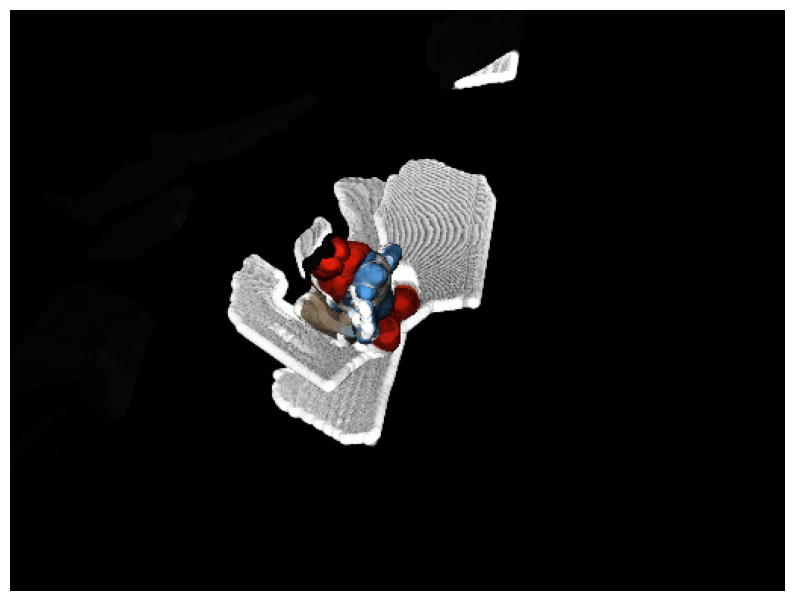

In [70]:
## Render Point Cloud

# Points Rasterization 설정
raster_settings = PointsRasterizationSettings(
    image_size=(384,512),    # 출력 이미지 크기
    radius=0.02,       # 각 점의 반경
    points_per_pixel=10,  # 픽셀당 최대 점 개수
    bin_size=64,
    max_points_per_bin=10_000_000
)

# PointsRenderer 설정
rasterizer = PointsRasterizer(cameras=cameras, raster_settings=raster_settings)
renderer = PointsRenderer(
    rasterizer=rasterizer,
    compositor=AlphaCompositor(background_color=(0, 0, 0))  # 배경색 설정
)

# Render the mesh
images = renderer(pointCloud)

# Display the result
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis("off")
plt.show()


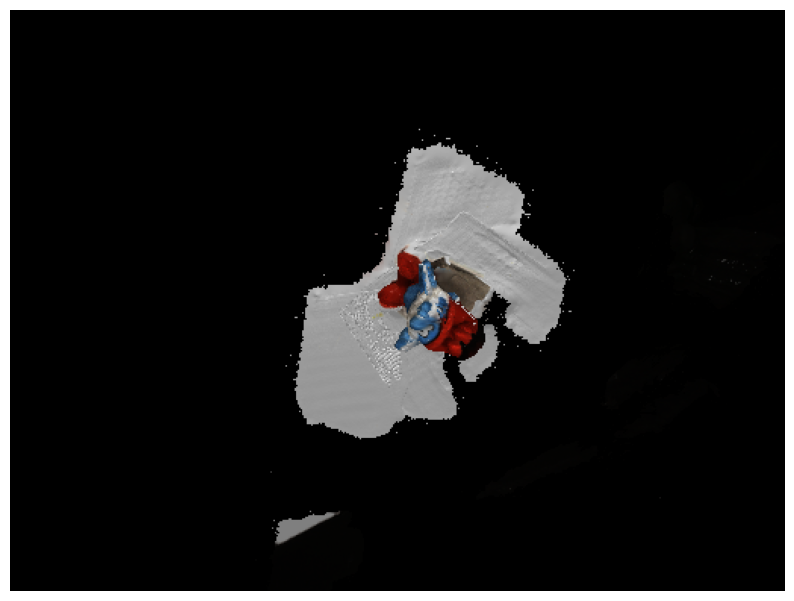

In [71]:
## Render Mesh

raster_settings = RasterizationSettings(
    image_size=(384,512),  # 출력 이미지 크기
    blur_radius=0.0,
    faces_per_pixel=1,
    bin_size=64,
    max_faces_per_bin=10_000_000
)

# 렌더러 생성
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(cameras=cameras, raster_settings=raster_settings),
    shader=HardPhongShader(device=device, cameras=cameras, blend_params=BlendParams(background_color=(0, 0, 0)))
)

# Mesh 렌더링
images = renderer(mesh)

# 결과 시각화
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis("off")
plt.show()

In [72]:
import plotly.io as pio
import plotly.graph_objects as go
from pytorch3d.vis.plotly_vis import plot_scene

# 카메라 시각화를 위한 데이터 생성
camera_origin = cameras.get_camera_center()[0].cpu().numpy()  # 카메라 위치
camera_direction = R[0, :, 2].cpu().numpy()  # Z축 방향 (카메라 시선)
camera_axes = R[0].cpu().numpy()  # 카메라 축 (X, Y, Z)

# 카메라 방향을 원뿔로 표현
camera_cone = go.Cone(
    x=[camera_origin[0]],
    y=[camera_origin[1]],
    z=[camera_origin[2]],
    u=[-camera_direction[0]],
    v=[-camera_direction[1]],
    w=[-camera_direction[2]],
    colorscale="Blues",
    showscale=False,
    sizemode="absolute",
    sizeref=0.5,
)

# 카메라 축 (X, Y, Z) 추가
camera_x_axis = go.Scatter3d(
    x=[camera_origin[0], camera_origin[0] + camera_axes[0, 0]],
    y=[camera_origin[1], camera_origin[1] + camera_axes[1, 0]],
    z=[camera_origin[2], camera_origin[2] + camera_axes[2, 0]],
    mode='lines',
    line=dict(color='red', width=4),
    name='X-Axis'
)
camera_y_axis = go.Scatter3d(
    x=[camera_origin[0], camera_origin[0] + camera_axes[0, 1]],
    y=[camera_origin[1], camera_origin[1] + camera_axes[1, 1]],
    z=[camera_origin[2], camera_origin[2] + camera_axes[2, 1]],
    mode='lines',
    line=dict(color='green', width=4),
    name='Y-Axis'
)
camera_z_axis = go.Scatter3d(
    x=[camera_origin[0], camera_origin[0] + camera_axes[0, 2]],
    y=[camera_origin[1], camera_origin[1] + camera_axes[1, 2]],
    z=[camera_origin[2], camera_origin[2] + camera_axes[2, 2]],
    mode='lines',
    line=dict(color='blue', width=4),
    name='Z-Axis'
)

# 포인트 클라우드와 카메라를 시각화
scene_dict = {"PointCloud": {"point_cloud": pointCloud}}
fig = plot_scene(scene_dict)

# 카메라 추가
fig.add_trace(camera_cone)
fig.add_trace(camera_x_axis)
fig.add_trace(camera_y_axis)
fig.add_trace(camera_z_axis)

# 시각화 출력
fig.show()

In [73]:
# world_coords = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5)

# o3d.visualization.draw_geometries([pcd_o3d, mesh_o3d, world_coords])